# Introduction, information about the neuron

Model `144976`. https://modeldb.science/144976  

Paper: Culmone V, Migliore M — Progressive effect of beta-amyloid peptides accumulation on CA1  pyramidal neurons: a model study suggesting possible treatments ((2012)

The model predicts possible therapeutic treatments of Alzheimers's Disease in terms of pharmacological manipulations of channels' kinetic and activation properties. The results suggest how and which mechanism can be targeted by a drug to restore the original firing conditions. The simulations reproduce somatic membrane potential in control conditions, when 90% of membrane is affected by AD (Fig.4A of the paper), and after treatment (Fig.4B of the paper). 

We have neuron with [173 sections](#number-of-sections)

## ▶️▶️ Setup and imports

In [5]:
from neuron import h, gui
from neuron import nrn_dll_sym, ctypes
from neuron import _WrapperPlot
from neuron.gui2.utilities import _segment_3d_pts

import sys
import time  # for timing experiments
import os
import json  # to save data
import numba
from numba import jit, njit, prange

import pyvista as pv
import meshio
import numpy as np
from scipy.interpolate import interp1d
np.bool = np.bool_  # dirty hack to fix a bug in pyvista where it uses np.bool that is deprecated

import pprint

# Plot one of the voltages:
import matplotlib.pyplot as plt

# use a scientific theme for the plots
plt.style.use('seaborn-v0_8-notebook')
# enable grid by default
plt.rcParams['axes.grid'] = True

# we will create animations!
import matplotlib.animation as animation
from IPython.display import HTML


### ▶️▶️ Load neuron model

In [6]:
h.load_file("mosinit.hoc")

1.0

### ▶️▶️ Helper functions

In [3]:
import textwrap

# This will be a useful function for future, to explore available functions for a NEURON object
def nrndir(obj):
    print(textwrap.fill(', '.join([x for x in dir(obj) if not x.startswith('_')])))
    
    
def nrnselsec(name):
    for sec in h.allsec():
        if sec.name() == name:
            return sec
    raise ValueError(f"Section {name} not found")

In [4]:
from scipy.interpolate import interp1d

def interp_along_axis(y, x, newx, axis):
    """Interpolate along a given axis of an array. Given an array y with shape (N, M), 
    array x with shape N and newx with shape L, this function interpolates y along the axis 0
    and outputs a newy array with shape (L, M). The interpolation is done using a linear interpolation.
    
    In general, if y is of shape (N, ..., K, ...), x should be of shape (K,) and newx of shape (L,) to give
    a newy of shape (N, ..., L, ...).

    This function assumes that the x-xoordinate increases monotonically
    """

    if y.shape[axis] != x.shape[0]:
        raise ValueError("y and x must have the same length along the axis to interpolate")
    
    newy_shape = list(y.shape)
    newy_shape[axis] = len(newx)
    newy = np.empty(newy_shape)

    newy = np.apply_along_axis(lambda y: interp1d(x, y, kind='linear', fill_value='extrapolate')(newx), axis, y)
    
    return newy

In [5]:
# Test interp_along_axis

y = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
x = np.array([0, 1, 2])
newx = np.array([0, 0.2, 0.3, 0.5, 0.7, 1.5, 2])
newy = interp_along_axis(y, x, newx, axis=0)

print("Old y with shape {}: {}".format(y.shape, y))
print("Provided x with shape {}: {}".format(x.shape, x))
print("Provided newx with shape {}: {}".format(newx.shape, newx))
print("Interpolated y with shape {}: {}".format(newy.shape, newy))

y = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
x = np.array([0, 1, 2])
newx = np.array([0, 0.2, 0.3, 0.5, 0.7, 1.5, 2])
newy = interp_along_axis(y, x, newx, axis=1)

print("Old y with shape {}: {}".format(y.shape, y))
print("Provided x with shape {}: {}".format(x.shape, x))
print("Provided newx with shape {}: {}".format(newx.shape, newx))
print("Interpolated y with shape {}: {}".format(newy.shape, newy))

Old y with shape (3, 3): [[1 2 3]
 [4 5 6]
 [7 8 9]]
Provided x with shape (3,): [0 1 2]
Provided newx with shape (7,): [0.  0.2 0.3 0.5 0.7 1.5 2. ]
Interpolated y with shape (7, 3): [[1.  2.  3. ]
 [1.6 2.6 3.6]
 [1.9 2.9 3.9]
 [2.5 3.5 4.5]
 [3.1 4.1 5.1]
 [5.5 6.5 7.5]
 [7.  8.  9. ]]
Old y with shape (3, 3): [[1 2 3]
 [4 5 6]
 [7 8 9]]
Provided x with shape (3,): [0 1 2]
Provided newx with shape (7,): [0.  0.2 0.3 0.5 0.7 1.5 2. ]
Interpolated y with shape (3, 7): [[1.  1.2 1.3 1.5 1.7 2.5 3. ]
 [4.  4.2 4.3 4.5 4.7 5.5 6. ]
 [7.  7.2 7.3 7.5 7.7 8.5 9. ]]


Some definitions of useful objects to use in what follows.

In [6]:
# ad33 = nrnselsec("apical_dendrite[33]")
ad33 = h.apical_dendrite[33]

## Units

What are the units for important quantities? 

<!-- table of units -->

| Quantity | Unit |
| --- | --- |
| Voltage | mV |
| Current | mA/cm² |
| Time | ms |
| Length | um |
| Diameter | um |
| Axial resistivity | Ω cm |


In [7]:
data = []
for sec in h.allsec():
    xs = [sec.x3d(i) for i in range(sec.n3d())]
    ys = [sec.y3d(i) for i in range(sec.n3d())]
    zs = [sec.z3d(i) for i in range(sec.n3d())]
    ds = [sec.diam3d(i) for i in range(sec.n3d())]
    data.append({
        "id": sec.hname(),
        "x": xs,
        "y": ys,
        "z": zs,
        "d": ds
        }
    )

In [8]:
dir(sec(0.5))  # accesses properties of a middle segment of the section

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'area',
 'cm',
 'diam',
 'ds',
 'hd',
 'k_ion',
 'kad',
 'kap',
 'kdr',
 'na3',
 'na_ion',
 'node_index',
 'pas',
 'point_processes',
 'ri',
 'sec',
 'v',
 'volume',
 'x']

In [9]:
pprint.pprint(data)

[{'d': [1.5,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0,
        1.0],
  'id': 'axon[0]',
  'x': [0.0,
        4.067999839782715,
        6.067999839782715,
        7.067999839782715,
        6.567999839782715,
        2.068000078201294,
        -1.931999921798706,
        -6.932000160217285,
        -8.432000160217285,
        -12.932000160217285,
        -15.932000160217285,
        -10.932000160217285,
        -10.932000160217285,
        -10.432000160217285,
        -7.932000160217285],
  'y': [0.0,
        8.0,
        15.0,
        23.5,
        30.5,
        37.0,
        42.0,
        46.0,
        46.0,
        46.5,
        48.0,
        52.5,
        55.5,
        58.5,
        61.5],
  'z': [7.500999927520752,
        14.52400016784668,
        14.52400016784668,
        13.52400016784668,
        14.52400016784668,
        19.52400016784668,
        

In [10]:
h.topology()


|-|       soma[0](0-1)
   `|       dendrite[0](0-1)
     `|       dendrite[1](0-1)
       `|       dendrite[2](0-1)
         `----|       dendrite[3](0-1)
         `------|       dendrite[4](0-1)
       `--------|       dendrite[5](0-1)
     `|       dendrite[6](0-1)
       `----|       dendrite[7](0-1)
       `|       dendrite[8](0-1)
         `----|       dendrite[9](0-1)
               `----|       dendrite[10](0-1)
               `----|       dendrite[11](0-1)
         `--|       dendrite[12](0-1)
             `----|       dendrite[13](0-1)
             `----|       dendrite[14](0-1)
   `--|       axon[0](0-1)
   `|       dendrite[15](0-1)
     `|       dendrite[16](0-1)
       `|       dendrite[17](0-1)
         `--|       dendrite[18](0-1)
             `--|       dendrite[19](0-1)
             `------|       dendrite[20](0-1)
         `|       dendrite[21](0-1)
           `|       dendrite[22](0-1)
             `------|       dendrite[23](0-1)
             `|       dendrite[24](

1.0

The results tell us section with name "apical_dendrite[67]" is a cylinder with length 100 microns, diameter 500 microns, axial resistivity 35.4 ohm*cm, and specific membrance capacitance 1 μF/cm2. To access specific properties, we can querry what is interesting to us:

There are interesting global values that should be noted, like temperature of the entire system:

In [11]:
h.celsius

35.0

We are now looking at how to run a stimulation that will trigger some action potential along the neuron. The stimulus is already encoded into the `.hoc` file, so I need to find to access it through Python, and then how to read the values obtained from there into a dictionary associated with the segments. 

From https://neuron.yale.edu/neuron/docs/scripting-neuron-basics:

A NEURON Section is considered a piece of cable. Depending on the resolution desired, it may be necessary to divide the cable into a number of segments where voltage varies linearly between centers of adjacent segments. The number of segments within a section is given by the variable, nseg. The total ionic current across the segment membrane is approximately the area of the segment multiplied by the ionic current density at the center of the segment. To access a part of the section, specify a value between 0 and 1, where 0 is typically the end closest to the soma and 1 is the distal end. Because nseg divides the cable into equal-length parts, it should be an odd number so that to address the middle of the cable, (0.5), gives the middle segment.

### Important notes:  
voltage varies linearly between centers of adjacent segments  
total curent is the area of the segment multiplied by the ionic current density at the center of the segment (what direction?)  
(what is the orienation of the section/segment?)  

In [12]:
# sec = nrnselsec("apical_dendrite[67]")  # this is what I previously used to select a section
sec = h.apical_dendrite[67]

sec.orientation()
# Returns 0.0 or 1.0  depending on the x value closest to parent.

0.0

In [13]:
sec.nseg

3

## Selecting a section

In [15]:
for sec in h.allsec():
    # find section with point processes
    pprocess = sec.psection()['point_processes']
    # check that this dictionary is not empty
    if pprocess:
        print(sec.hname())
        print(pprocess)
        print()

soma[0]
{'APCount': {APCount[0]}}



Finally I understood that! It adds a section instead of finding an existing one. I need to find a way to access the existing sections.

To find what function returns me an existing section by name, I need to look at the documentation. I found the `h.SectionRef` class, which is a reference to a section, but it uses section object as an input, i.e. I already need to have a section accessible. Instead, let's look at the `dir(h)` and 

## Selecting an apical dendrite section

I gave up looking for a way to access the sections by name, and instead I will iterate over all sections and find the one I need, if I need one, like so:

In [14]:
name = "apical_dendrite[67]"
for sec in h.allsec():
    if sec.name() == name:
        apical_dendrite = sec
        pprint.pprint(sec.psection())
        break


{'Ra': 150.0,
 'cell': None,
 'cm': [1.0, 1.0, 1.0],
 'density_mechs': {'ds': {'vmax': [0.0, 0.0, 0.0]},
                   'hd': {'ghdbar': [0.00019253559889345935,
                                     0.00021501997856845136,
                                     0.00023750435824344338],
                          'i': [0.0, 0.0, 0.0],
                          'l': [0.0, 0.0, 0.0],
                          'vhalfl': [-81.0, -81.0, -81.0]},
                   'kad': {'gka': [0.0, 0.0, 0.0],
                           'gkabar': [0.008, 0.008, 0.008],
                           'l': [0.0, 0.0, 0.0],
                           'n': [0.0, 0.0, 0.0]},
                   'kap': {'gka': [0.0, 0.0, 0.0],
                           'gkabar': [0.008, 0.008, 0.008],
                           'l': [0.0, 0.0, 0.0],
                           'n': [0.0, 0.0, 0.0]},
                   'kdr': {'gkdr': [0.0, 0.0, 0.0],
                           'gkdrbar': [0.01, 0.01, 0.01],
                         

In fact, I can select any section like this by changing the `name` variable.

In [18]:
apical_dendrite.n3d()

11

## Guess about what is the number of points in a section and what is the number of segments

Number of points in the section define its 3D shape and only that. Number of segments define the resolution of the section for the voltage and current simulation purposes, and only. From the documentation, and Important notes in this document, I understand that the voltage varies linearly between the centers of adjacent segments, but that is not relevant for the 3D shape of the section.

## Running a NEURON simulation from Python

Let's try to record voltages and other variables of interest from the section `apical_dendrite` that I selected

In [16]:
v = h.Vector().record(apical_dendrite(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In the loaded `.hoc` file, there is a run function `runm` available. I will try to run it and see what happens.

In [17]:
h.superrun()

0.0

Let's check that voltages and time are recorded correctly:

In [18]:
v.as_numpy()

array([-65.        , -65.        , -65.        , ..., -65.02097193,
       -65.0199561 , -65.0199561 ])

Now I want to explore what I have available for this object `v`.

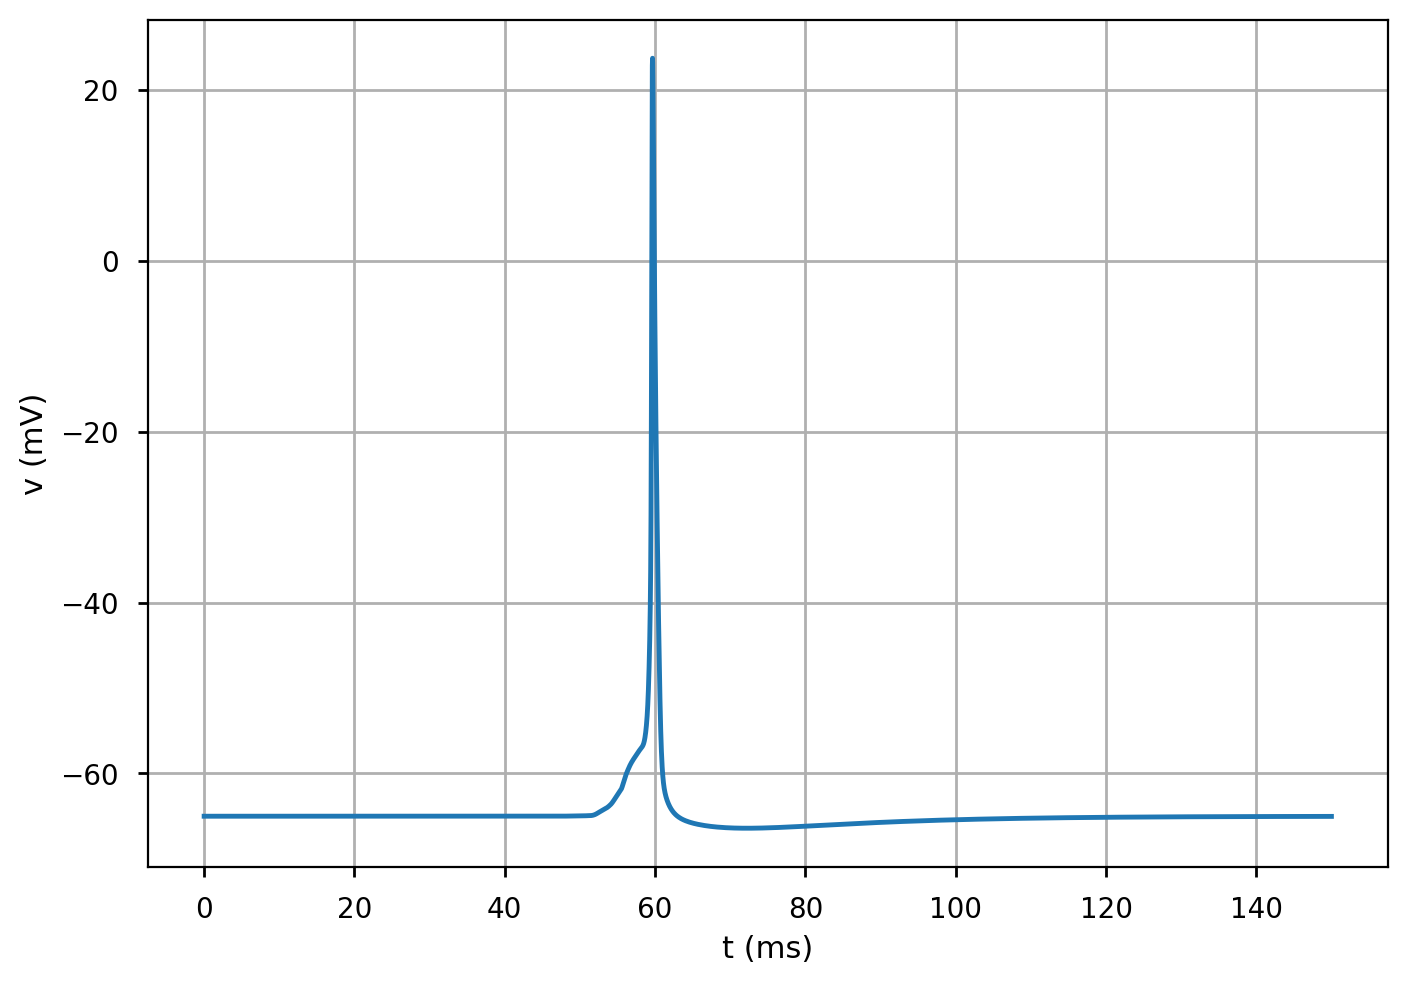

In [19]:
plt.figure()
plt.plot(t, v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

# Extracting voltage and currents from each segment

Here I will extract all values computed during the `runm` simulation relevant to the magnetic field calculation: currents, and also voltages for checking purposes. First, let's see what is available for each segment, check the variables present for segments and sections, and find their meaning. Then I will draw relevant values on the segment-section representation of the neuron, to visualize how they contribute to the magnetic field.

In [20]:
apical_dendrite = h.apical_dendrite[67]

# Segment values
print("Segment attributes:")
nrndir(apical_dendrite(0.5))
print("\nSection attributes:")
nrndir(apical_dendrite)

Segment attributes:
area, cm, diam, ds, hd, k_ion, kad, kap, kdr, na3, na_ion, node_index,
pas, point_processes, ri, sec, v, volume, x

Section attributes:
L, Ra, allseg, arc3d, cell, children, connect, diam3d, disconnect,
has_membrane, hname, hoc_internal_name, insert, is_pysec, n3d, name,
nseg, orientation, parentseg, psection, pt3dadd, pt3dchange,
pt3dclear, pt3dinsert, pt3dremove, pt3dstyle, push, rallbranch, same,
spine3d, subtree, trueparentseg, uninsert, wholetree, x3d, y3d, z3d


In [21]:
h.dendrite[9].nseg

5

In [22]:
h.dendrite[9].n3d()

23

In [23]:
apical_dendrite.arc3d(5)

21.890901824731376

In [24]:
apical_dendrite.name()

'apical_dendrite[67]'

In [25]:
apical_dendrite.psection()

{'point_processes': {},
 'density_mechs': {'pas': {'g': [3.571428571428572e-05,
    3.571428571428572e-05,
    3.571428571428572e-05],
   'e': [-63.69141635638702, -51.67187436032529, -51.544134399419875],
   'i': [-4.744726187156953e-05,
    -0.0004767172049537497,
    -0.0004812795084259375]},
  'ds': {'vmax': [25.380239074618213, 23.70746916452937, 23.056724949813937]},
  'hd': {'ghdbar': [0.00019253559889345935,
    0.00021501997856845136,
    0.00023750435824344338],
   'vhalfl': [-81.0, -81.0, -81.0],
   'i': [-0.0007984300960267249,
    -0.0008934045966913506,
    -0.0009877192032152554],
   'l': [0.11841602127082591, 0.11864618303473179, 0.11875345680921737]},
  'kad': {'gkabar': [0.0, 0.06300399571369028, 0.06750087164868868],
   'gka': [0.0, 5.5045573978779794e-05, 5.897440133051769e-05],
   'n': [0.001188986704318441, 0.0011889845840927944, 0.0011889839994163188],
   'l': [0.7348147421040787, 0.734815125986419, 0.7348152311596449]},
  'kap': {'gkabar': [0.058507119778691864,

Currents available in the segment are:

$i_{\text{pas}}$ - passive current from Chlorine ions `["pas"]["i"]`
$i_{\text{Na}}$ - Sodium current `["ions"]["na"]["ina"]`
$i_{\text{K}}$ - Potassium current `["ions"]["k"]["ik"]`
$i_{\text{hd}}$ - current that exists in the distal dendrites only 

We can check the number of sections:

#### Number of sections

In [26]:
i = 0
for sec in h.allsec():
    i += 1
    
print(i)

173


#### Number of segments
To calculate the total number of segments, we can sum the number of segments in each section:

In [27]:
def print_n_segments():
    n = 0
    for sec in h.allsec():
        n += sec.nseg
    print("Number of segments in the model is: ", n)

print_n_segments()

Number of segments in the model is:  559


In [28]:
def print_n_3dpts():
    n = 0
    for sec in h.allsec():
        n += sec.n3d()
    print("Number of 3d points in the model is: ", n)

print_n_3dpts()

Number of 3d points in the model is:  2416


Remember to use suffix syntax for currents generated by density mechanisms and dot syntax for currents generated by point processes. Also remember that point process currents are in absolute units (uA) but density mechanism currents are in mA/cm2, so the latter should be multiplied by segment area; scaling will be necessary because hoc's area(x) reports the area of the segment that contains location x in units of um2.

https://www.neuron.yale.edu/phpbb/viewtopic.php?p=6398&hilit=hd+density_mech#p6398

To find all existing current in the model, we will iterate through all sections and find in `.psection()` all keys, including in the subdictionaries that start with `i` or `I` in them. We will then return a dictionary with those names of currents as keys, and the names of the sections as values.

In [29]:
from collections import defaultdict

def find_leaves_and_build_dict(h):
    result = defaultdict(lambda: defaultdict(dict))

    def recursive_search(sub_dict, path, section_name):
        for k, v in sub_dict.items():
            new_path = path + [k]
            if isinstance(v, list) and k.startswith("i"):
                current = result
                for p in new_path[:-1]:  # Traverse path except the last element
                    current = current[p]
                if k not in current:
                    current[k] = []
                current[k].append(section_name)
            elif isinstance(v, dict):
                recursive_search(v, new_path, section_name)

    for sec in h.allsec():
        section_name = sec.name()
        prop = sec.psection()
        recursive_search(prop, [], section_name)
    
    return {k: dict(v) for k, v in result.items()}

def convert_leaves_to_lengths(d):
    if isinstance(d, dict):
        return {k: convert_leaves_to_lengths(v) for k, v in d.items()}
    elif isinstance(d, list):
        return len(d)
    return d

# Get the dictionary with only the branches where such leaves exist
filtered_dict = find_leaves_and_build_dict(h)
convert_leaves_to_lengths(filtered_dict)

{'density_mechs': {'pas': {'i': 173}, 'hd': {'i': 172}},
 'ions': {'na': {'ina': 173}, 'k': {'ik': 173}}}

## ▶️▶️ Run simulation and extract voltages in time per section

Now we will extract voltages at each segment with time. For that, we need to create a record vector like this

```
v = h.Vector().record(apical_dendrite(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
```

but for each segment, and store it together with the segment. Let's try that. 

In [125]:
h.load_file(1, "membrane_potential.hoc")

	1 
	1 
	1 
	1 
	1 
	Vector[6396] 
	Vector[6397] 
	Vector[6398] 
	1 
	0 
	0 


1.0

In [ ]:
h.test()

test


0.0

: 

In [110]:
def extract_vt():
    """Runs NEURON simulation and records values of voltage in each of section segment in time. 
    The output is a dictionary with keys as section names, i.e. apical_dendrite[33], and values are 
    arrays, containing `nseg` vectors from NEURON with voltages. Each such vector contains values of 
    voltage (in mV) for a particula segment of the section in a neuron, and each value is the particular
    voltage at time t. Time t is specified at "t" key. 
    
    ASSUMPTION: I assume that time t is identical for all segments during the simulation. But it might 
    not be the case if there is varying granularity in time for certain segments with specific dynamics. 
    """
    vt_dict = {}
    vt_dict["t"] = h.Vector().record(h._ref_t)

    for sec in h.allsec():
        vt_dict[sec.name()] = {"v": []}
        # for seg in sec:
        for seg in sec.allseg():
            v = h.Vector().record(seg._ref_v)
            vt_dict[sec.name()]["v"].append(v)
            vt_dict[sec.name()]["sec"] = sec
                    
    h.superrun()
    return vt_dict


In [111]:
vt_dict = extract_vt()

In [32]:
# Let's check what's the size in memory of this dictionary when all vectors are empty
import sys
size_in_bytes = sys.getsizeof(vt_dict)
size_in_kb = size_in_bytes / 1024
print(f"Size of the dictionary in memory: {size_in_bytes} bytes, {size_in_kb} KB")

Size of the dictionary in memory: 6576 bytes, 6.421875 KB


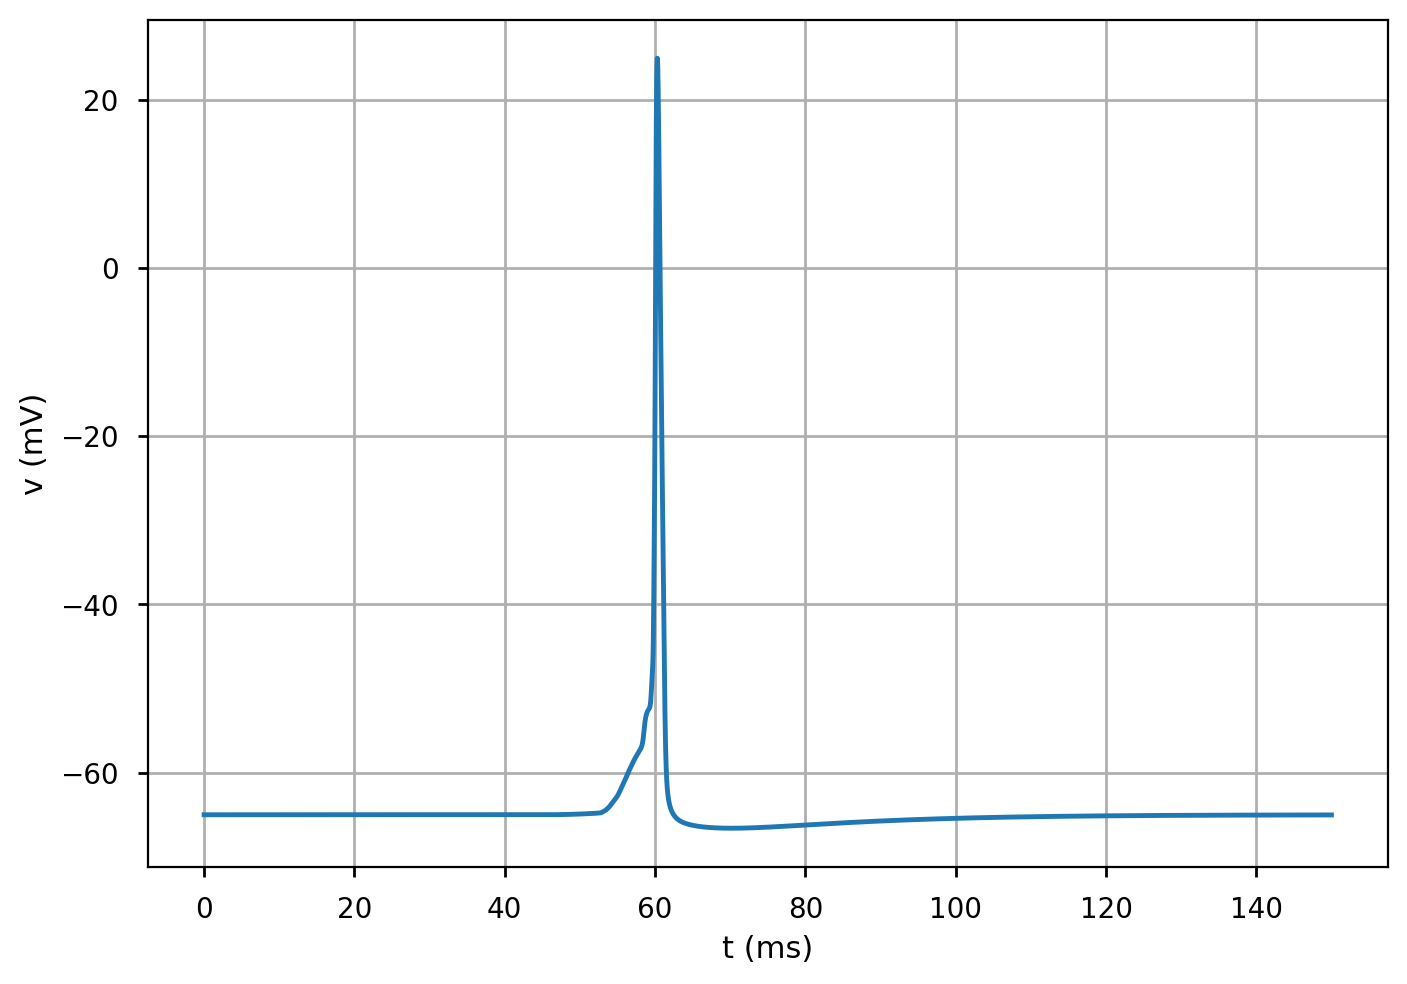

In [33]:
plt.plot(vt_dict["t"].as_numpy(), vt_dict['axon[0]']["v"][0].as_numpy())
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.grid(True)



In [34]:
ad33 = h.apical_dendrite[33]
ad33.L

111.34469368078238

In [36]:
# Add sequentially segment lengths of the section to check if the length adds up
lengths = []
l = 0

x, y, z, _ = ad33.psection()['morphology']['pts3d'][0]
r = np.array([x, y, z])

for x, y, z, _ in ad33.psection()['morphology']['pts3d'][1:]:
    p = np.array([x, y, z])
    l = np.linalg.norm(p - r)
    r = p
    lengths.append(l)
    
print("Total length of the section: ", np.array(lengths).sum())
print("Declared length of the section: ", ad33.L)
    

Total length of the section:  111.34469312610508
Declared length of the section:  111.34469368078238


In [37]:
ad33(0.4).v

-65.03403529427055

### Explode result values

Below we use the result `dict`, `vt_dict`, and populate it with relevant values for mesh creation and magnetic field calculation.

In [38]:
def get_arc_lengths(sec, cumulative=False):
    """Return fractional coordinates of 3d points along the section."""
    lengths = np.empty((sec.n3d(), ))
    L = sec.L

    x, y, z = sec.x3d(0), sec.y3d(0), sec.z3d(0)
    r = np.array([x, y, z])
    lengths[0] = 0.
    
    for i in range(sec.n3d()-1):
        p = np.array([sec.x3d(i+1), sec.y3d(i+1), sec.z3d(i+1)])
        l = np.linalg.norm(p - r)
        r = p
        if cumulative:
            lengths[i+1] = lengths[i] + l
        else:
            lengths[i+1] = l

    if cumulative and lengths[-1] - L > 1e-6:        
        # manually correct the last value to be equal to the section length
        lengths[-1] = L
    
    return lengths
        
        
def explode_3d_vt_dict(vt_dict):
    """Requires a dictionary with keys as section names and values as dictionaries with keys "v" populated with
    voltage vectors from NEURON from simultion. 
    
    Returns: a dictionary with keys as section names and values
             where values are interpolated voltage values at 3d points along the section, 
             contrary to the values returned per segment in the original dictionary.
             
             Populates the dictionary of the section with keys:
                - "v" for the interpolated voltage values at 3d points along the section
                - "I" for the current values between every two points along the section
                - "pts3d" for the 3d points along the section
                - "diam" for the diameters of the section at each 3d point
                - "arc3d" for the cumulative lengths along the section from the beginning for every 3d point
                - "sec" for the NEURON section object
    """
    res_dict = {}
    for key, sec_dict in vt_dict.items():
        if key == "t":
            res_dict["t"] = sec_dict.as_numpy()
            continue
        
        sec = sec_dict["sec"]
        
        diameters = np.array([sec.diam3d(i) for i in range(sec.n3d())])
        voltages = np.array([v.as_numpy() for v in sec_dict["v"]])
        
        # for each key, we need to extract voltage values at each segment
        x = np.array([seg.x for seg in sec.allseg()]) * sec.L
        arc3d = get_arc_lengths(sec, cumulative=True)
        pts3d = np.array([[sec.x3d(i), sec.y3d(i), sec.z3d(i)] for i in range(sec.n3d())])
        newvoltages = interp_along_axis(voltages, x, arc3d, axis=0)
        res_dict[key] = {"v": newvoltages}
        
        # calculate current values
        axial_resistance = sec.Ra  # in Ohm * cm
        axial_resistance *= 1e4 # in Ohm * um
        
        # cross-sectional area of the 3d segments
        middle_diams = (diameters[1:] + diameters[:-1]) / 2
        A = middle_diams ** 2 * np.pi / 4  # in um^2
        
        axial_resistance_per_unit_length = axial_resistance / A  # in Ohm / um
        segment_resistances = np.diff(arc3d) * axial_resistance_per_unit_length  # in Ohm
        
        currents = -1 * np.diff(newvoltages, axis=0) / segment_resistances[:, None]  # -1 is important!
        # there is a mistake in Karadas paper
        
        res_dict[key] = {
            "v": newvoltages, 
            "I": currents, 
            "pts3d": pts3d,
            "diam": diameters, 
            "arc3d": arc3d, 
            "sec": sec}
    
    return res_dict
        
        


In [39]:
vt_dict = extract_vt()

In [40]:
res_dict = explode_3d_vt_dict(vt_dict)

In [41]:
# check if there are weird voltage values anywhere in the res_dict
for key, sec_dict in res_dict.items():
    if key == "t":
        continue
    voltages = sec_dict["v"]
    if np.any(np.isnan(voltages)) or np.any(np.isinf(voltages)) or np.any(voltages > 100) or np.any(voltages < -100):
        print(f"Section {key} has NaN, Inf or |V| > 100 values in the voltage array.")

Plot the voltages for in `apical_dendrite[35]` section at each segment as a function of time.

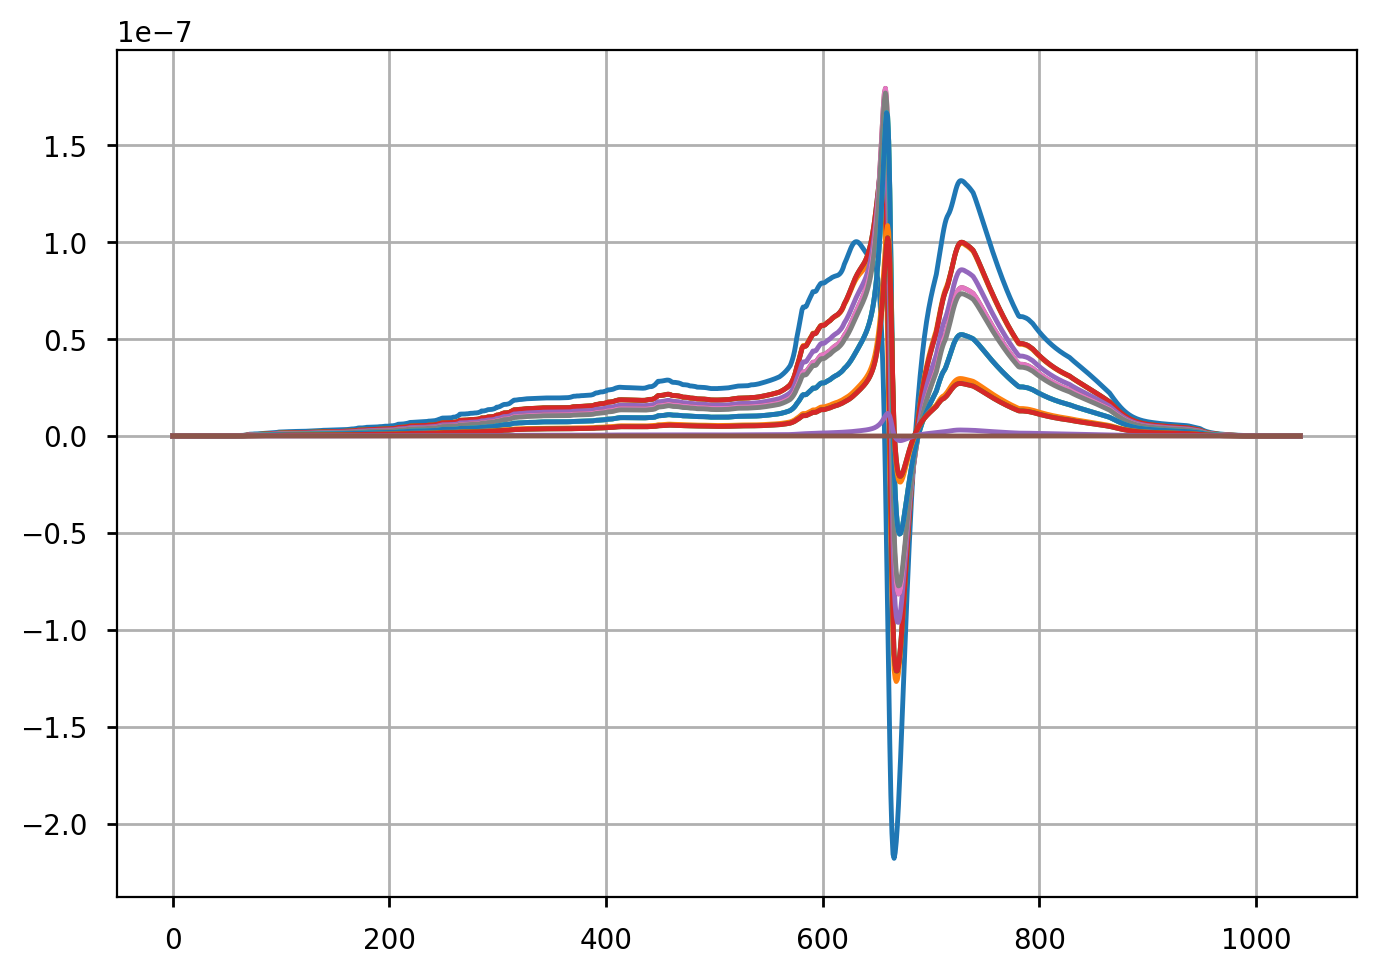

In [43]:
plt.plot(res_dict["apical_dendrite[35]"]["I"][:, :].T)

Text(140.41791534306535, -64.97708668837052, 'dendrite[27], t=173')

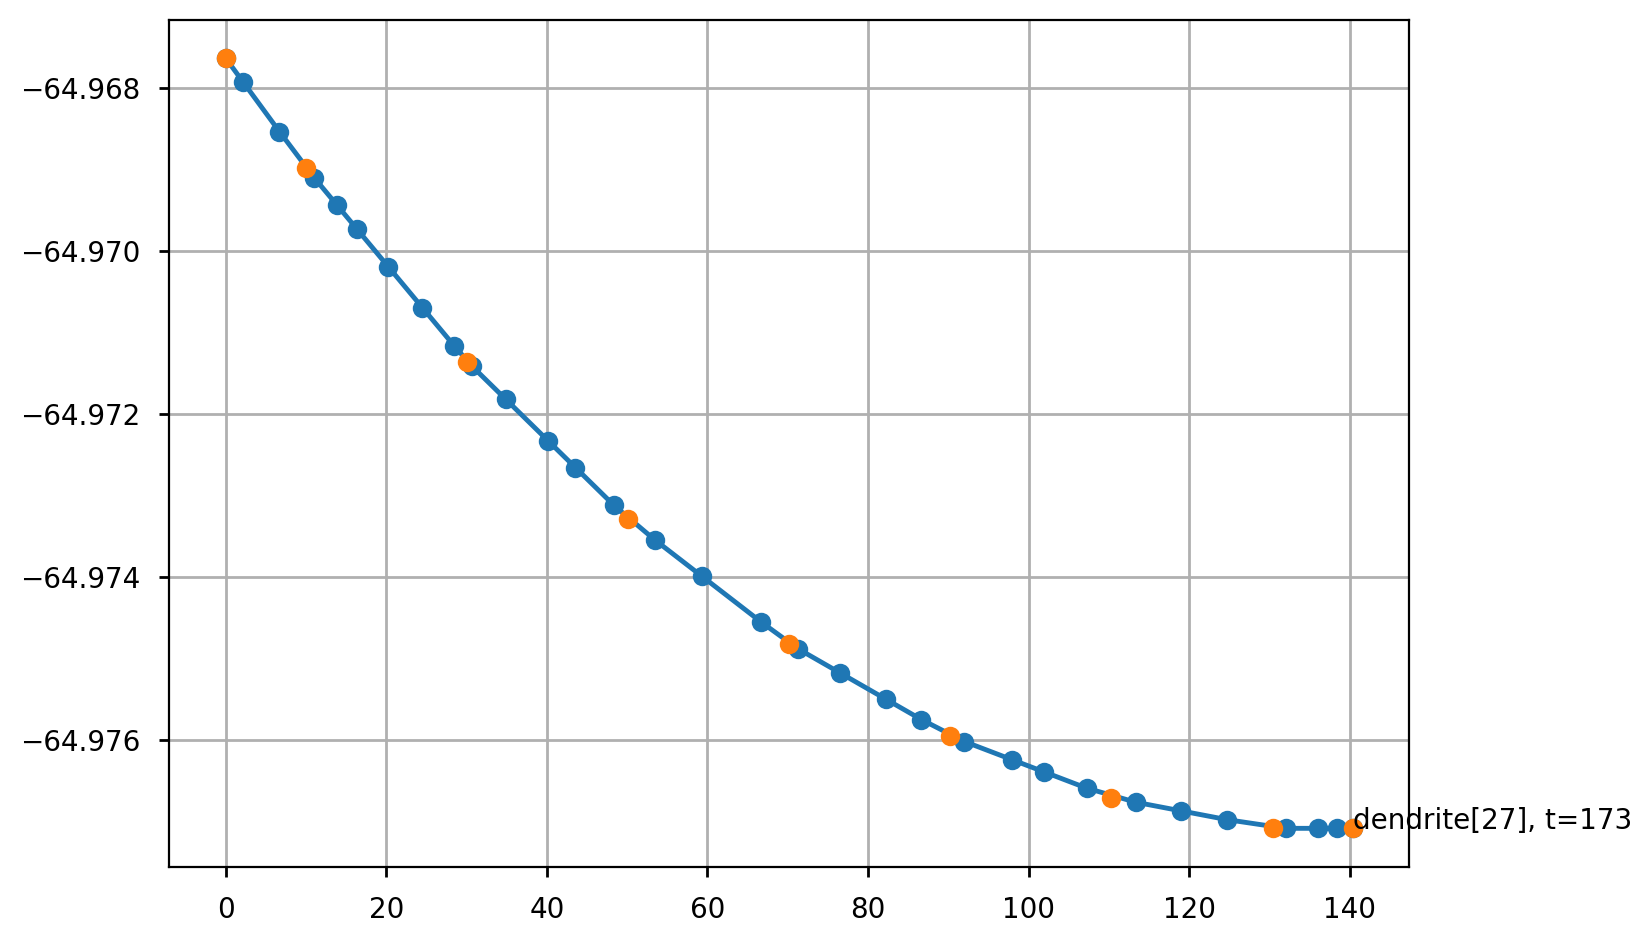

In [50]:
# plot a random voltage with arc3d values to check if the interpolation is correct
random_key = np.random.choice(list(res_dict.keys()))
random_sec_dict = res_dict[random_key]
random_t = np.random.choice(list(range(len(res_dict["t"]))))
random_v_interp = random_sec_dict["v"][:, random_t]
random_arc3d = random_sec_dict["arc3d"]
random_v = np.array([v.as_numpy() for v in vt_dict[random_key]["v"]])[:, random_t]
random_x = np.array([seg.x for seg in random_sec_dict["sec"].allseg()]) * random_sec_dict["sec"].L
plt.plot(random_arc3d, random_v_interp, marker='o')
plt.plot(random_x, random_v, marker='o', linestyle='')
plt.text(random_arc3d[-1], random_v_interp[-1], f"{random_key}, t={random_t}")

3d points span regions of constant voltage as it is returned by the `v` vector. In different segments of the section, the voltage is different, and it changes with time.
Current between different 3d points is determined by the current in the segment that contains the point. 

To compute the magnetic field, we can write an efficient function that will calculate the magnetic field at a point in space due to the current in a single section. Signature of the function will be

```python
def magnetic_field_at_point(x, y, z, section, t):
    ...
    return Bx, By, Bz
```

# Computing magnetic field

Now we create a function that computes the magnetic field according to the formula from [1], Eq. S17 of Supplementary Material. 

$$
\mathbf{B}(\mathbf{r}, \mathrm{t})=\frac{\mu_0}{4 \pi} \sum_{n=1}^{n} \frac{\mathbf{I}_{\mathrm{axial}}^{n}(\mathrm{t}) \times \hat{\rho}_{n}}{\rho_{n}}\left[\frac{\mathrm{h}_{n}}{\sqrt{\mathrm{h}_{n}^2+\rho_{n}^2}}-\frac{l_{n}}{\sqrt{l^2_{n}+\rho_{n}^2}}\right]\qquad(S17)
$$

where $\mathbf{I}_{\mathrm{axial}}^{n}(\mathrm{t})$ is the axial current in the $n$-th segment, $\hat{\rho}_{n}$ is the unit vector pointing from the $n$-th segment to the point of interest, $\rho_{n}$ is the distance from the $n$-th segment to the point of interest, $\mathrm{h}_{n}$ is the distance from the $n$-th segment to the point of interest along the segment, and $l_{n}$ is the length of the $n$-th segment.

Axial current $\mathbf{I}_{\mathrm{axial}}^{n}(\mathrm{t})$ is defined, according to the simplification in the paper, as 

$$
\mathbf{I}_{\mathrm{axial}}^{n}(\mathrm{t}) = \frac{v_m^n-v_m^{n-1}}{\Delta s_n r^n_i} \hat{l}_n\,,\quad (S16)
$$
where $v_m^n$ is the membrane potential at the center of the $n$-th segment, $\Delta s_n$ is the length of the $n$-th segment, and $r^n_i$ is the axial resistivity of the $n$-th segment.

M. Karadas, A. M. Wojciechowski, A. Huck, N. O. Dalby, U. L. Andersen, and A. Thielscher, “Feasibility and resolution limits of opto-magnetic imaging of neural network activity in brain slices using color centers in diamond,” Scientific Reports, 2018, doi: [10.1038/s41598-018-22793-w](http://doi.org/10.1038/s41598-018-22793-w).


### Components for the magnetic field calculation

Looking at formula (S17), we can see that we need a way, for each segment $n$, to calculate the following components:

1. $\mathbf{I}_{\mathrm{axial}}^{n}(\mathrm{t})$ - axial current in the $n$-th segment
2. $\hat{\rho}_{n}$ - radial unit vector pointing from the $n$-th segment to the point of interest (that is, radial unit vector in cylindrical system of coordinates aligned with the direction of the segment)
3. $\rho_{n}$ - radial distance from the $n$-th segment to the point of interest
4. $\mathrm{h}_{n}$ - distance from the end of the $n$-th segment to the point of interest along the segment (that is, $z$ coordinate in cylindrical system of coordinates aligned with the direction of the segment)
5. $l_{n}$ - length of the $n$-th segment
6. $\hat{l}_{n}$ — unit vector pointing along the segment, for the calculation of $\mathbf{I}_{\mathrm{axial}}^{n}(\mathrm{t})$

Note that above by segment we mean not the segments to which voltage simulation is broken up into, but the segments of the neuron morphology, that is, consequitive 3d points in the morphology that are connected by a line.

Let's concieve a function that will calculate the components $\hat{\rho}_{n}$, $\rho_{n}$, $\mathrm{h}_{n}$, $\hat{l}_n$, and $l_{n}$ for a given segment and a point in space. It accepts two points in space as beginning and end of the segment, and a point in space as the point of interest. It returns the components as listed above.

```python
def rhohl(segment_begin: (x0, y0, z0), segment_end: (x1, y0, z0), point_of_interest: (x, y, z)):
    ...
    return rho_hat, rho, h, l_hat, l
```

To get $\mathrm{h}_{n}$, we can find a unit vector in the direction along the section, $\hat{l}_n$, and then project the vector from the segment to the point of interest onto this unit vector.

Let's call the vector going from any point of the segment to the point of interest $\mathbf{R_{n}}$.

The vector $\mathbf{\mathrm{\hat{\rho}_n}}$ is slightly more difficult. To find it, we need to obtain a unit vector that is perpendicular to $\hat{l}_n$ and that lies in the same plane as the vector $\mathbf{R_{n}}$. We can do it by taking a vector product twice: 

- first to get an out-of-plane vector perpendicular to both $\mathbf{R_{n}}$ and $\hat{l}_n$, 

$$
\vec{a} = \mathbf{R_{n}} \times \hat{l}_n
$$

- and then to get the in-plane vector $\hat{\rho}_n$ perpendicular to ${\hat{l}_{n}}$ by finding a cross product of ${\hat{l}_{n}}$ with $a$:

$$
\hat{\rho}_n = \hat{l}_{n} \times \vec{a} / |\vec{a}|
$$


Below we define function that use purely numpy to be able to optimize them with numba for faster computations. 
We define vector creation function and lead field matrix calculation function.

In [42]:
@njit
def rhohl(sbeg, send, pt):
    """Given the start and end points of a segment, and a point, calculate rho_hat, rho, h, l_hat, l_norm parameters
    for the segment with relation to that point."""
    l = send - sbeg
    l_norm = np.linalg.norm(l)
    l_hat = l / l_norm
    
    R = pt - send
    a = np.cross(l_hat, R)
    rho_hat = np.cross(a, l_hat) / np.linalg.norm(a)
    rho = np.dot(R, rho_hat)
    
    h = np.dot(R, l_hat)
    
    return rho_hat, rho, h, l_hat, l_norm + h

@njit
def cross_product_matrix(v):
    """Given a vector v, calculate its cross product matrix such that 
    matrix * u = np.cross(v, u) for any vector u."""
    return np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])

@njit
def unit_magnetic_field(pt, sbeg, send):
    """Calculate the magnetic field produced by a unit current along the segment sbeg-send at point in space `pt`.
    
    Returns the unit magnetic field vector in T / A.
    """
    
    rho_hat, rho, h, l_hat, l_norm = rhohl(sbeg, send, pt)
    
    factor = (h / np.sqrt(h**2 + rho**2) - l_norm / np.sqrt(l_norm**2 + rho**2)) / rho
    unit_B = 1e-1 * np.cross(l_hat, rho_hat) * factor  # 1e-1 is mu_0 / 4pi in units of T * um / A
    
    return unit_B

@njit
def get_ffm(pts3d, pts):
    """Get the forward field matrix for the unit magnetic field along the segments defined by pts3d at points of space `pts`."""
    ffm = np.empty((3, len(pts), len(pts3d) - 1))
    for i, pt in enumerate(pts):
        for j in range(len(pts3d) - 1):
            ffm[:, i, j] = unit_magnetic_field(pt, pts3d[j], pts3d[j+1])
    return ffm

def get_b(pts3d, pts, I):
    """Calculate the magnetic field at points `pts` in space due to a current I along the segments defined by pts3d."""
    ffm = get_ffm(pts3d, pts)
    # k - component of the magnetic field, p - point in space, s - segment, t - time
    return np.einsum('kps,st->kpt', ffm, I, optimize=True)


@njit
def get_b_njit(pts3d, pts, I):
    """Calculate everything in one loop and compile it with numba."""
    nt = I.shape[1]  # number of time points
    B = np.zeros((3, len(pts), nt))
    for i, pt in enumerate(pts):
        for j in range(len(pts3d) - 1):
            for t_idx in range(nt):
                B[:, i, t_idx] += unit_magnetic_field(pt, pts3d[j], pts3d[j+1]) * I[j, t_idx]
    return B

In [43]:
# Compare time it takes to compute b field with `get_b` vs. `get_b_njit`

I = res_dict["apical_dendrite[13]"]["I"]
pts3d = res_dict["apical_dendrite[13]"]["pts3d"]
pts = np.random.rand(10, 3)

# Measure time for get_b
start_time = time.time()
b_field = get_b(pts3d, pts, I)
time_get_b = time.time() - start_time

# Measure time for get_b_njit
start_time = time.time()
b_field_njit = get_b_njit(pts3d, pts, I)
time_get_b_njit = time.time() - start_time

# Compare results
print("Time for get_b:", time_get_b)
print("Time for get_b_njit:", time_get_b_njit)
print("Outputs close:", np.allclose(b_field, b_field_njit))

Time for get_b: 1.1025807857513428
Time for get_b_njit: 0.49809789657592773
Outputs close: True


In [44]:
# Test cross product matrix
v = np.array([1, 2, 3])
u = np.array([4, 5, 6])
print(cross_product_matrix(v))
print("Result np.cross(v, u): ", np.cross(v, u))
print("Result of matrix @ u: ", cross_product_matrix(v) @ u)

[[ 0 -3  2]
 [ 3  0 -1]
 [-2  1  0]]
Result np.cross(v, u):  [-3  6 -3]
Result of matrix @ u:  [-3  6 -3]


In [45]:
sec = h.apical_dendrite[33]
sbeg = np.array([sec.x3d(0), sec.y3d(0), sec.z3d(0)])
send = np.array([sec.x3d(1), sec.y3d(1), sec.z3d(1)])

print("Beginning of the segment: ", sbeg)
print("End of the segment: ", send)

pt = np.array([-50, 280, 10])

rhohl(sbeg, send, pt)

Beginning of the segment:  [-37.20999908 260.41000366 -14.98899937]
End of the segment:  [-40.79999924 260.32998657 -10.4989996 ]


(array([0.20305767, 0.96257145, 0.17950986]),
 20.745435146680286,
 21.47988238520766,
 array([-0.62442244, -0.01391768,  0.78096281]),
 27.229195542002067)

Now use `pyvista` to visualize this vectors: beginning of the segment, end of the segment, point of interest, $\mathbf{R_{n}}$, $\hat{l}_n$, $\mathbf{\mathrm{\hat{\rho}_n}}$.

In [46]:
sbeg, send = res_dict["apical_dendrite[14]"]["pts3d"][0:2]

# Calculate vectors and values
rho_hat, rho, hh, _, l_norm = rhohl(sbeg, send, pt)
R = pt - send
l_hat = (send - sbeg) / l_norm

# Set up the plot
plotter = pv.Plotter()

# Add the segment
plotter.add_mesh(pv.Line(sbeg, send), color='blue', line_width=5, label='Segment')

# Add the point of interest
plotter.add_mesh(pv.Sphere(center=pt, radius=0.5), color='red', label='Point of Interest')

# Add the R vector
plotter.add_mesh(pv.Line(send, pt), color='green', line_width=3, label='R_n')

# Add the l_hat vector (from sbeg to sbeg + l_hat)
plotter.add_mesh(pv.Arrow(start=send, direction=l_hat, scale=l_norm, shaft_radius=0.002), color='yellow', label='l_hat')
plotter.add_mesh(pv.Arrow(start=send, direction=l_hat * hh, scale=hh, shaft_radius=0.002), color='yellow', label='h')

# Add the rho_hat vector (from send to send + rho_hat)
plotter.add_mesh(pv.Arrow(start=send, direction=rho_hat, scale=l_norm, shaft_radius=0.002), color='magenta', label='rho_hat')
plotter.add_mesh(pv.Arrow(start=send, direction=rho_hat * rho, scale=rho, shaft_radius=0.002), color='magenta', label='rho')

# Display the plot with labels
plotter.add_legend()
plotter.show()

Widget(value='<iframe src="http://localhost:64614/index.html?ui=P_0x3116b45d0_0&reconnect=auto" class="pyvista…

Note that above `segment` is a part of a neuron in 3D geometry, and not the `segment` in the voltage simulation. What we should do now is to find the current flowing through the segment. For middle segments `0 < i < n-1`, it is easy. For the first and the last segment, the current depends on the neighboring section. In the first approximation, we can just extract the voltages at the end of the neighbouring segments and use them to find the difference of voltages. 

For `n3d` points in the section, we have `n3d`-1 segments. Let's make a function that outputs the corresponding `n3d`-1 currents.

The function we want first will take a section and output voltage at 21 different points:

What is above is good, but it uses current values of the voltage and does not account for the fact that voltage changes in time. So we need to adjust this function to use recorded values of voltage in time. 

For that we will use the dictionary `vt_dict` that is produced by `extract_vt` function in section “Extract voltages for sections”. It has all the information we need. We will essentially explode it with interpolated values at 3d points instead of segment values.

### Extract voltages into a line mesh

This is an alternative approach to exploding a dictionary with values. Instead we rely on PyVista and VTK extensive mesh capabilities to interpolate values along splines. 

First we will construct line splines with diameter values as scalars. Then we will place points along each section with votlage values and interpolate them along the line splines.

I've found this GitHub issue that achieves what I want: finding a point along a spline that is `distance` away from its origin: https://github.com/pyvista/pyvista/discussions/3123 and also the same code present in `PyVista` documentation: https://docs.pyvista.org/examples/02-plot/distance-along-spline.html

It should work for neuron section splines too!

In [56]:
def convert_neuron_vectors_to_numpy(vt_dict):
    # deep copy the dictionary to avoid modifying the original
    res = {}
    for key, sec_dict in vt_dict.items():
        if key == "t":
            res["t"] = sec_dict.as_numpy()
        else:
            res[key] = {"v": np.array([v.as_numpy() for v in sec_dict["v"]]), "sec": sec_dict["sec"]}
    return res    

In [57]:
vt_dict = convert_neuron_vectors_to_numpy(vt_dict)

In [60]:
sec_spline = pv.Spline(np.array([(sec.x3d(i), sec.y3d(i), sec.z3d(i)) for i in range(sec.n3d())]))
dists = np.array([seg.x for seg in sec.allseg()]) * sec.L
voltages = vt_dict[sec.name()]["v"][:, 220]

In [61]:
t_idx = 220
voltages = vt_dict[sec.name()]["v"][:, t_idx]
dists = np.array([seg.x for seg in sec.allseg()]) * sec.L
interp_voltages = interp1d(dists, voltages, kind='linear')

# udpate result spline with the interpolated voltages
result = sec_spline.copy()
result["voltage"] = interp_voltages(result["arc_length"])
result["diameter"] = np.array([sec.diam3d(i) for i in range(sec.n3d())])

currents = np.diff(interp_voltages(result["arc_length"])) / np.array([sec.arc3d(i) for i in range(sec.n3d())])[1:]

Let's try creating a mesh for a section with lines, instead of a spline. The hope is that it will have number of cells equal to the number of points - 1, so that we can assign currents to cells.

In [58]:
def get_section_line_mesh(sec, vt_dict, t_idx):
    """Return a mesh of the section as a line. Computes and stores the voltages, currents and diameters
    along the section as point and cell data."""
    points = []
    diameters = []
    lines = []
    
    for i in range(sec.n3d()):
        x, y, z, d = sec.x3d(i), sec.y3d(i), sec.z3d(i), sec.diam3d(i)
        points.append((x, y, z))
        diameters.append(d)
        if i < sec.n3d() - 1:
            lines.append([2, i, i+1])
            
    diameters = np.array(diameters)
    
    polydata = pv.PolyData()
    polydata.points = points
    polydata.lines = lines
    polydata["diameters"] = diameters
    polydata = polydata.compute_arc_length()
    
    voltages = vt_dict[sec.name()]["v"][:, t_idx]
    v_dists = np.array([seg.x for seg in sec.allseg()]) * sec.L
    seg_lengths = polydata.point_data["arc_length"]
    pt_dists = np.cumsum(seg_lengths)
    interp_voltages = interp1d(v_dists, voltages, kind='linear', 
                               bounds_error=False)(pt_dists)
    
    axial_resistance = sec.Ra  # ohm*cm
    axial_resistance *= 1e4  # ohm*um
    
    # cross-sectional area of the 3d segments
    middle_diameters = (diameters[:-1] + diameters[1:]) / 2  # find the middle diameter between two points
    A = middle_diameters ** 2 * np.pi / 4  # um^2
    
    axial_resistance_per_unit_length = axial_resistance / A  # ohm / um
    
    currents = np.diff(interp_voltages) / (seg_lengths[1:] * axial_resistance_per_unit_length)

    polydata.point_data["voltages"] = interp_voltages
    polydata.cell_data["currents"] = currents
    
    return polydata

sec_line = get_section_line_mesh(sec, vt_dict, t_idx)

In [59]:
get_section_line_mesh(sec, vt_dict, 100)

PolyData (0x315b80040)
  N Cells:    20
  N Points:   21
  N Strips:   0
  X Bounds:   -1.115e+02, -3.721e+01
  Y Bounds:   2.603e+02, 3.150e+02
  Z Bounds:   -1.499e+01, 3.024e+01
  N Arrays:   4

### Get currents, directions of the segments in 3d geometry    

In [60]:
print(get_arc_lengths(sec).shape)
print(res_dict[sec.name()]["v"].shape)
print(res_dict[sec.name()]["pts3d"].shape)

(21,)
(21, 1042)
(21, 3)


In [61]:
# List all sections with no parent segment:
for sec in h.allsec():
    if sec.parentseg() is None:
        print(sec)

soma[0]


Now that we have interpolated values of voltage, we can assign current to every 3d point in the section, by taking the difference of the voltages at the ends of the segment and dividing it by the length of the segment.

In formula (S16), $r_i^n$ is the axial resistance per unit length, in units of $\Omega \cdot \text{cm}^{-1}$. We can find it by dividing the axial resistivity given by `section(0.5).Ra` by the area of the cross-section of the segment.

In [62]:
h.units("Ra")

'ohm-cm'

So we will ignore soma in the calculations of currents, for now. Some has only one voltage value, and 4 connected sections, but it is unclear how much current actually flows through the some and in what direction.

### Calculate field matrix per section 

So far so good. We have `res_dict`, which is obtained from an expanded version of voltage dictionary `vt_dict` that has interpolated values of voltage at 3d points. In `res_dict`, we have currents with key "I" per section, and a list of directions of this currents (3d segments) 
with key "l_hat". That is almost all we need to compute the magnetic field at a point in space due to the currents in the section, according to formula (S17).

Function `unit_magnetic_field(pt, sbeg, send)` makes that: it assumes a unit current of 1 A flowing through a 3d segment of a section, and calculates the magnetic field at a point in space due to this unit current at a point. We need to compute this result for all points in space and for all 3d segments of a section, so get the magnetic field matrix for a section.

Options to make it somewhat efficient is to use numpy arrays and vectorize the calculations. How do we break the matrices into smaller parts? We can use `np.meshgrid` to create a grid of points in space, and then create a matrix per each section that will connect the magnetic field at those points with the currents in the 3d segments of the section. Currents are contained in the `res_dict` dictionary with key "I", and directions of the currents are contained in the `res_dict` dictionary with key "l_hat". 

```python
res_dict = {
    "I": currents,
    "l_hat": directions
}
```

Shape of those arrays is `(n3d, 3)`, where `n3d` is the number of 3d points in the section.

In [71]:
print(res_dict["apical_dendrite[14]"]["l_hat"].shape)
print(res_dict["apical_dendrite[14]"]["I"].shape)
print(res_dict["apical_dendrite[14]"]["pts3d"].shape)
print(res_dict["apical_dendrite[14]"]["loc3d"].shape)

KeyError: 'l_hat'

In [89]:
def add_ffm(vt_dict, pts):
    """Populates the dictionary with forward field matrix (FFM).
    
    Args:
        vt_dict: dictionary with voltage values and other properties of the section
        pts: points in space where the magnetic field is calculated

    The forward field matrix is a matrix that describes the relationship between the current in the segment and the
    magnetic field produced by this current at the point in space. The matrix is of size (3, nseg), where the first
    number is the i-component of the magnetic field, and the second number is the j-th 3d segment of the section.
    
    To obtain the magnetic field at points in space produced by the section, 
    we need to multiply the forward field matrix by the current at the segment:
    
        B_section = FFM @ I
        
    where B_section is of shape (3, n_pts, nt), FFM is of shape (3, n_pts, n_seg) and I is of shape (n_seg, nt)
    """
    
    for key, sec_dict in vt_dict.items():
        if key == "t":
            continue
        
        sec = sec_dict["sec"]
       
        ffm = np.empty((3, len(pts), len(sec_dict["l_hat"])))
        for i, pt in enumerate(pts):
            for j in range(len(sec_dict["pts3d"]) - 1):
                ffm[:, i, j] = unit_magnetic_field(pt, sec_dict["pts3d"][j], sec_dict["pts3d"][j+1])
        
        sec_dict["ffm"] = ffm
        
    return vt_dict

In [27]:
# Create a 3D grid with Pyvista
xrng = np.linspace(-200, 200, 100, dtype=np.float32)
yrng = np.linspace(-300, 600, 100, dtype=np.float32)
zrng = np.linspace(0, 150, 20, dtype=np.float32)
x, y, z = np.meshgrid(xrng, yrng, zrng, indexing='ij')

grid = pv.StructuredGrid(x, y, z)

In [132]:
# res_dict = add_ffm(res_dict, grid.points)

In [93]:
res_dict["apical_dendrite[14]"]["ffm"].shape

(3, 200000, 21)

This is correct! It took 23 minutes to calculate the forward field matrix for all section. Now we iterate through section, calculate the field matrix for each section, and add it up to find the total field at `grid.points.shape[0]` points in space.

Now for each section we need to extract a list of direction vectors along the segments of the section. 

In [63]:
def get_B_from_all_sec(vt_dict):
    """Calculate the magnetic field at points in space from all sections."""
    nt = vt_dict["t"].size()
    npts = len(grid.points)
    B = np.zeros((3, npts, nt), dtype=np.float64)
    for key, sec_dict in vt_dict.items():
        if key == "t":
            continue
        
        I = sec_dict["I"]
        ffm = sec_dict["ffm"]
        B += ffm @ I

    return B

In [110]:
B = get_B_from_all_sec(res_dict)

It takes 2m 50s to calculate the total field produced by all 173 sections at 200000 points in space at 414 points in time once the field matrix is precalculated.

In [126]:
count_sections = 0
for sec in h.allsec():
    count_sections += 1
print(count_sections)

173


In [114]:
B.shape

(3, 200000, 414)

### Calculate the magnetic field from a section

Above it took in total 23 minutes to first precompute the field matrix for all sections, and then 2m 50s to calculate the total field produced by all 173 sections at 200000 points in space at 414 points in time. What if we don't precompute the field matrix for all sections, but calculate it on the fly? 

It will take less memory, but what about the time?

In [64]:
def get_B_at_pts(pts, res_dict):
    """Iterate over all sections in `res_dict` and calculate the magnetic field at points in space."""
    nt = res_dict["t"].size
    B = np.zeros((3, len(pts), nt), dtype=np.float64)
    
    for key, sec_dict in res_dict.items():
        if key == "t":
            continue
        
        I = sec_dict["I"]
        B += get_b(sec_dict["pts3d"], pts, I)
        
    return B

Create a grid using `pyvista` so that the result of the computation is also stored efficiently in an Exodus file. 

In [50]:
mesh.bounds

(-130.56575988458087,
 162.67662601117883,
 -207.51792479271947,
 562.0040832951944,
 -93.41900026798248,
 92.1377285803984)

In [53]:
x0, x1, y0, y1, z0, z1 = mesh.bounds
xrng = np.linspace(x0 * 1.1, x1 * 1.1, 100, dtype=np.float32)
yrng = np.linspace(y0 * 1.1, y1 * 1.1, 100, dtype=np.float32)
zrng = np.linspace(z0 * 1.5, z1 * 1.5, 100, dtype=np.float32)

In [54]:
x, y, z = np.meshgrid(xrng, yrng, zrng, indexing='ij')
big_grid = pv.StructuredGrid(x, y, z)

In [55]:
big_grid_B = get_B_at_pts(big_grid.points, res_dict)

In [67]:
xrng = np.linspace(-250, 250, 100, dtype=np.float32)
yrng = np.linspace(-200, 500, 100, dtype=np.float32)
zrng = np.linspace(2.5e4, 100, 1, dtype=np.float32)
x, y, z = np.meshgrid(xrng, yrng, zrng, indexing='ij')
diamond_grid = pv.StructuredGrid(x, y, z)

In [58]:
print(diamond_grid.points.shape)
diamond_B = get_B_at_pts(diamond_grid.points, res_dict)

(10000, 3)


In [59]:
t_idx = 220
diamond_grid["B"] = diamond_B[:, :, t_idx].transpose(1, 0)

In [60]:
diamond_grid.plot(show_axes=True, clim=[0, 1e-10])

Widget(value='<iframe src="http://localhost:51894/index.html?ui=P_0x34bf54f10_2&reconnect=auto" class="pyvista…

It only took 9 minutes! Faster twice than prestoring the matrix. Maybe with a `numba` optimization it can be even faster, but we would need to manually iterate through time points. 

In [38]:
B.shape

(3, 200000, 414)

In [39]:
grid.point_data['B'] = B.transpose(1, 0, 2)

In [58]:
big_grid.point_data['B'] = big_grid_B.transpose(1, 0, 2)
ts = res_dict["t"]

In [61]:
output_dir = "magfield_big"
os.makedirs(output_dir, exist_ok=True)
for i, t in enumerate(ts):
    big_grid.point_data['B'] = big_grid_B[:, :, i].transpose(1, 0) * 1e-3  # convert units to T from mT
    big_grid.save(output_dir + f'/magnetic_field_{i}.vtk')

In [63]:
big_grid_B.shape

(3, 1000000, 414)

In [52]:
grid.save("magnetic_field.vtk")

Now our goal is to store temporal distribution of the field in a format compatible with VTK, so that I can visualize it with ParaView.

I asked ChatGPT for that, and it suggested linking files with fields at each time steps. I will try to do that:

Above approach didn't work. For two reasons:

1. ParaView could not open the individual files specified in the `.pvd` file. It gave error "Could not open file". Possible reasons: wrong file path, maybe it is resolved relative to a different directory.
2. Individual `.vtk` files were not openned correctly either. They were loaded, but showed that there are 3 timesteps, as if every field component was a timestep.

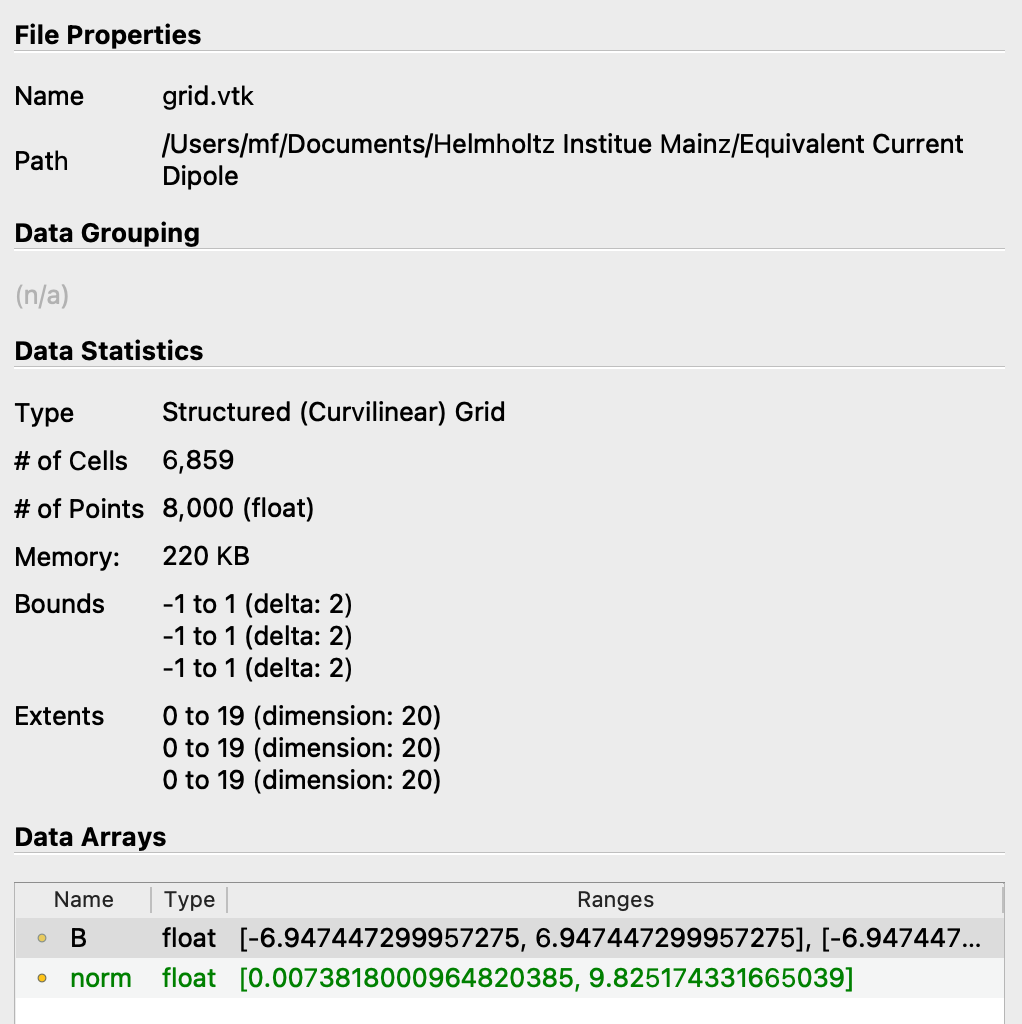

I don't know what happened, I just exited and entered the folder again in ParaView, and it recognized the timesteps correctly. Only issue is that timesteps are not marked accordingly to the actual time. But that can be solved I suppose with a `.timeseries` file in JSON format.

In [131]:
grid["B"].shape

(200000, 3)

I tried to first preconstruct the FFM matrix for field calculations, but it takes too much memory. Instead, let's create a fast function that will, for a given section with `nseg` segments and `N` pts in space, create this matrix on the fly, and then multiply it with the currents to get the magnetic field at the points in space produced by the section. 

In [102]:
(res_dict["apical_dendrite[14]"]["ffm"] @ res_dict["apical_dendrite[14]"]["I"]).shape

(3, 200000, 414)

# 3D visualization of a neuron

Below is a failed attempt to set a `vtkDataSet` with temporal voltage data per point. What works in `ParaView` is a mysterious Exodus file format or a series of `.vtk` files with the same structure. 

In [65]:
def get_section_mesh_at_time_t(sec, res_dict, t_idx=0):
    # Iterate through all sections and extract points and diameters
    pts3d = np.array(sec.psection()['morphology']['pts3d'])
    points = pts3d[:, :3]  # remove the last value, because it is diameter
    diameters = pts3d[:, 3]
    voltages = res_dict[sec.name()]["v"][:, t_idx]
    currents = res_dict[sec.name()]["I"][:, t_idx]
    ls = res_dict[sec.name()]["arc_lengths"]
    
    # Implement one section - one line policy
    if len(points) > 2:
        spline = pv.Spline(points, len(points))
    else:
        spline = pv.Line(points[0], points[1])
    
    spline['diameter'] = diameters
    spline['voltage'] = voltages
    spline['currents'] = np.interp(np.linspace(0, ls[-1], len(voltages)), ls, currents)
    spline.field_data['time'] = res_dict["t"].as_numpy()[t_idx]
    
    spline = spline.interpolate(spline, sharpness=10.0)
    
    return spline.tube(radius=0.5, scalars='diameter', capping=True, absolute=True)

def get_neuron_mesh_at_time_t(sec_mesh_func, res_dict, t_idx=0):
    neuron_meshes = {sec.name(): sec_mesh_func(sec, res_dict, t_idx=t_idx) for sec in h.allsec()}
    # return pv.merge(neuron_meshes)     # -- merge produces a simpler file format
    return pv.MultiBlock(neuron_meshes)  # -- MutliBlock has advantage of storing section names properly

In [66]:
plotter = pv.Plotter()

mesh = get_section_mesh_at_time_t(h.apical_dendrite[14], res_dict, t_idx=220)
plotter.add_mesh(mesh, cmap='hot', clim=[-70, 20])

# for sec in h.allsec():
#     mesh = get_section_mesh(sec)
#     plotter.add_mesh(mesh, scalars='diameter', cmap='viridis')
    
plotter.show()

KeyError: 'arc_lengths'

In [175]:
pl = pv.Plotter()
pl.add_mesh(neuron_mesh, scalars='currents', cmap='hot')
pl.show()

/opt/homebrew/Caskroom/miniconda/base/envs/neuron/lib/python3.11/site-packages/pyvista/core/dataset.py:896: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(arr), np.nanmax(arr)


Widget(value='<iframe src="http://localhost:64254/index.html?ui=P_0x34ce20a10_25&reconnect=auto" class="pyvist…

I see above that there are segments with too high currents. I suspect a numerical error, due to interpolation, or distance calculation. To debug, I will need to extract all currents into a dictionary and inspect it.

In [67]:
# Find where values of the current are > 100

for key, sec_dict in res_dict.items():
    if key == "t":
        continue
    indx, vals = np.where(sec_dict["I"] > 1e-5)
    if len(indx) > 0:
        print(key)
        print(np.array(list(zip(indx, vals))))

In [68]:
[seg.x for seg in sec.allseg()]

[0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

#### Create a mesh of the neuron

In [69]:
def get_section_mesh_at_time_t(sec, res_dict, t_idx=0):
    # Iterate through all sections and extract points and diameters
    pts3d = res_dict[sec.name()]["pts3d"]
    diameters = res_dict[sec.name()]["diam"]
    voltages = res_dict[sec.name()]["v"][:, t_idx]
    currents = res_dict[sec.name()]["I"][:, t_idx]
    
    lines = []

    for i in range(len(pts3d)):
        if i < sec.n3d() - 1:
            lines.append([2, i, i+1])
    
    polydata = pv.PolyData()
    polydata.points = pts3d
    polydata.lines = lines
    
    polydata["diameters"] = diameters
    polydata["voltages"] = voltages
    polydata["currents"] = currents
    
    return polydata.tube(radius=0.5, scalars='diameters', capping=True, absolute=True)


# Example function to convert MultiBlock to a mesh object
def convert_multiblock_to_mesh(multiblock):
    # Assuming each block in the MultiBlock is a mesh, merge them
    if isinstance(multiblock, pv.MultiBlock):
        all_blocks = []
        for block in multiblock:
            if isinstance(block, pv.PolyData):
                all_blocks.append(block)
        # Merge all blocks into a single mesh
        if all_blocks:
            merged_mesh = pv.PolyData()
            for block in all_blocks:
                merged_mesh += block
            return merged_mesh
    # If it's not a MultiBlock, return as is
    return multiblock


def get_sections_mesh_at_time_t(secs, res_dict, t_idx=0, section_mesh_func=get_section_mesh_at_time_t):
    if not isinstance(secs, list):
        return section_mesh_func(secs, res_dict, t_idx=t_idx)
    
    if len(secs) == 0:
        raise ValueError("No sections provided.")
    
    meshes = [section_mesh_func(sec, res_dict, t_idx=t_idx) for sec in secs]
    return pv.MultiBlock(meshes)

def get_neuron_mesh_at_time_t(res_dict, t_idx=0, merge_blocks=True, section_mesh_func=get_section_mesh_at_time_t):
    neuron_meshes = {sec.name(): section_mesh_func(sec, res_dict, t_idx=t_idx) 
                     for sec in h.allsec()}
    if merge_blocks:
        return pv.MultiBlock(neuron_meshes)
    # return pv.merge(neuron_meshes)     # -- merge produces a simpler file format
    return pv.MultiBlock(neuron_meshes)  # -- MutliBlock has advantage of storing section names properly

In [70]:
mesh = get_sections_mesh_at_time_t(list(h.allsec()), res_dict, t_idx=700)
pl = pv.Plotter()
pl.add_mesh(mesh, scalars='voltages', cmap='hot', clim=[-70, 20])
pl.show()

Widget(value='<iframe src="http://localhost:64614/index.html?ui=P_0x3461d4fd0_4&reconnect=auto" class="pyvista…

#### Export timeseries mesh

In [71]:
def export_timeseries_mesh(mesh_func, filename, res_dict, extension="vtm", output_dir="vtk_time_series"):
    """Use `mesh_func` to create a mesh at each time point and save it to a series of files
    and produce a .series file that can be opened in ParaView to create an animation."""
    if not isinstance(res_dict["t"], np.ndarray):
        ts = res_dict["t"].as_numpy()
    else:
        ts = res_dict["t"]
        
    files = []
    os.makedirs(output_dir, exist_ok=True)
    for i, t in enumerate(ts):
        mesh = mesh_func(res_dict, t_idx=i)
        file_path = os.path.join(output_dir, f"{filename}_{i}.{extension}")
        mesh.save(file_path)
        files.append({"name": file_path, "time": t})
        
    series_file = os.path.join(output_dir, f"{filename}.{extension}.series")
    with open(series_file, "w") as f:
        json.dump(files, f)

        
def export_timeseries_mesh_with_meshio(mesh_func, filename, res_dict, output_dir="vtk_time_series"):
    """Use meshio to export to XMDF time series format."""
    ts = res_dict["t"].as_numpy()
    os.makedirs(output_dir, exist_ok=True)
    # for i, t in enumerate(ts):
    #     mesh = mesh_func(res_dict, t_idx=i)
    #     # if isinstance(mesh, pv.MultiBlock):
    #     #     mesh = convert_multiblock_to_mesh(mesh)
    #     meshio.write(os.path.join(output_dir, f"{filename}_{i}.xdmf"), mesh)
    
    from meshio._vtk_common import vtk_to_meshio_type
    
    vtk_to_meshio_type.update({
        2: 'poly_vertex',
        4: 'poly_line',
        6: 'triangle_strip',
        7: 'polygon',
        11: 'voxel',
        # Add any missing types here
    })

    # def pyvista_mesh_to_meshio(mesh):
    #     # Convert MutliBlock to PolyData
    #     if isinstance(mesh, pv.MultiBlock):
    #         mesh = convert_multiblock_to_mesh(mesh)
        
    #     # Cast to pyvista.UnstructuredGrid
    #     if not isinstance(mesh, pv.UnstructuredGrid):
    #         mesh = mesh.cast_to_unstructured_grid()

    #     # Copy useful arrays to avoid repeated calls to properties
    #     vtk_offset = mesh.offset
    #     vtk_cells = mesh.cells
    #     vtk_cell_type = mesh.celltypes

    #     # Get cells
    #     cells = {k: [] for k in np.unique(vtk_cell_type)}
    #     if 8 in cells.keys():
    #         cells[9] = cells.pop(8)                 # Handle pixels
    #     if 11 in cells.keys():
    #         cells[12] = cells.pop(11)               # Handle voxels
    #     mapper = {k: [] for k in cells.keys()}      # For cell data
        
    #     # for i, (offset, cell_type) in enumerate(zip(vtk_offset, vtk_cell_type)):
    #     #     numnodes = vtk_cells[offset]
    #     #     cell = vtk_cells[offset+1:offset+1+numnodes]
    #     #     cell = cell if cell_type not in {8, 11} \
    #     #         else cell[[ 0, 1, 3, 2 ]] if cell_type == 8 \
    #     #         else cell[[ 0, 1, 3, 2, 4, 5, 7, 6 ]]
    #     #     cell_type = cell_type if cell_type not in {8, 11} else cell_type+1
    #     #     cells[cell_type].append(cell)
    #     #     mapper[cell_type].append(i)
        
    #     for i, (offset, cell_type) in enumerate(zip(vtk_offset, vtk_cell_type)):
    #         numnodes = vtk_cells[offset]
    #         cell = vtk_cells[offset + 1:offset + 1 + numnodes]
    #         if cell_type == 8:
    #             cell = cell[[0, 1, 3, 2]]
    #         elif cell_type == 11:
    #             cell = cell[[0, 1, 3, 2, 4, 5, 7, 6]]
    #         cell_type = cell_type if cell_type not in {8, 11} else cell_type + 1
            
    #         meshio_type = vtk_to_meshio_type.get(cell_type)
    #         if meshio_type not in cells:
    #             cells[meshio_type] = []
    #             mapper[meshio_type] = []
            
    #         cells[meshio_type].append(cell)
    #         mapper[meshio_type].append(i)
        
    #     cells = {vtk_to_meshio_type[k]: np.vstack(v) if len(v) > 0 else [] for k, v in cells.items()}
    #     mapper = {vtk_to_meshio_type[k]: v for k, v in mapper.items()}

    #     # Get point data
    #     point_data = {k.replace(" ", "_"): v for k, v in mesh.point_arrays.items()}

    #     # Get cell data
    #     vtk_cell_data = mesh.cell_arrays
    #     cell_data = {
    #         k: {kk.replace(" ", "_"): vv[v] for kk, vv in vtk_cell_data.items()}
    #         for k, v in mapper.items()
    #     } if vtk_cell_data else {}
        
    #     points = np.array(mesh.points)
    #     return points, cells, point_data, cell_data
    
    
    def pyvista_mesh_to_meshio(mesh):
        """Convert a PyVista mesh to a format compatible with meshio."""
        if isinstance(mesh, pv.MultiBlock):
            mesh = convert_multiblock_to_mesh(mesh)
        if not isinstance(mesh, pv.UnstructuredGrid):
            mesh = mesh.cast_to_unstructured_grid()

        vtk_offset = mesh.offset
        vtk_cells = mesh.cells
        vtk_cell_type = mesh.celltypes

        # Initialize cells and mapper dictionaries
        cells = {k: [] for k in np.unique(vtk_cell_type)}
        if 8 in cells.keys():
            cells[9] = cells.pop(8)                 # Handle pixels
        if 11 in cells.keys():
            cells[12] = cells.pop(11)               # Handle voxels
        mapper = {k: [] for k in cells.keys()}      # For cell data
        
        for i, (offset, cell_type) in enumerate(zip(vtk_offset, vtk_cell_type)):
            numnodes = vtk_cells[offset]
            cell = vtk_cells[offset + 1:offset + 1 + numnodes]
            if cell_type == 8:
                cell = cell[[0, 1, 3, 2]]
            elif cell_type == 11:
                cell = cell[[0, 1, 3, 2, 4, 5, 7, 6]]
            cell_type = cell_type if cell_type not in {8, 11} else cell_type + 1
            
            meshio_type = vtk_to_meshio_type.get(cell_type)
            if meshio_type not in cells:
                cells[meshio_type] = []
                mapper[meshio_type] = []
            
            cells[meshio_type].append(cell)
            mapper[meshio_type].append(i)

        cells = {k: np.vstack(v) for k, v in cells.items()}
        mapper = {k: v for k, v in mapper.items()}

        point_data = {k.replace(" ", "_"): v for k, v in mesh.point_arrays.items()}

        vtk_cell_data = mesh.cell_arrays
        cell_data = {
            k: {kk.replace(" ", "_"): vv[v] for kk, vv in vtk_cell_data.items()}
            for k, v in mapper.items()
        } if vtk_cell_data else {}

        points = np.array(mesh.points)
        return points, cells, point_data, cell_data
    
    points, cells, _, _ = pyvista_mesh_to_meshio(mesh_func(res_dict, t_idx=0))
        
    with meshio.xdmf.TimeSeriesWriter(filename) as writer:
        writer.write_points_cells(points, cells)
        for i, t in enumerate(ts):
            _, _, point_data, cell_data = pyvista_mesh_to_meshio(mesh_func(res_dict, t_idx=i))
            writer.write_data(t, point_data=point_data, cell_data=cell_data)

Helper calculation to calculate the needed frame rate, so that the total animation duration is `anim_duration` seconds.

In [72]:
ts = res_dict["t"]
anim_duration = 5
print(ts.min(), ts.max())

scale = (ts.max() - ts.min()) / len(ts)
print(scale)

# Frame rate: number of frames / total_time
# I want animation to be `anim_duration` seconds long
frame_rate = len(ts) / anim_duration
print("Frame rate:", frame_rate)

0.0 150.0
0.14395393474088292
Frame rate: 208.4


In [93]:
extension = "vtm"
output_dir = "vtk_time_series"
filename = "neuron_mesh"
files = []
file_paths = []
ts = res_dict["t"]

for i, t in enumerate(ts):
        file_path = os.path.join(output_dir, f"{filename}_{i}.{extension}")
        file_paths.append(file_path)
        files.append({"name": file_path, "time": t})
        
series_file = os.path.join(output_dir, f"{filename}.{extension}.series")
# create folder if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
with open(series_file, "w+") as f:
    json.dump({"file-series-version": 1.0, "files": files}, f, indent=4)
    
def create_pvd_file(filename, timesteps, file_paths, output_dir):
    pvd_content = f'''<VTKFile type="Collection" version="0.1" byte_order="LittleEndian">
    <Collection>
'''
    for t, file_path in zip(timesteps, file_paths):
        pvd_content += f'        <DataSet timestep="{t}" file="{file_path}"/>\n'
    
    pvd_content += '''    </Collection>
</VTKFile>'''
    
    pvd_file = os.path.join(output_dir, f"{filename}.pvd")
    with open(pvd_file, "w") as f:
        f.write(pvd_content)
        
create_pvd_file(filename, ts, file_paths, output_dir)

In [94]:
mesh_func = lambda res_dict, t_idx: get_neuron_mesh_at_time_t(res_dict, t_idx=t_idx)
export_timeseries_mesh(mesh_func, "neuron_mesh", res_dict, output_dir="vtk_time_series")

I went against using `.json` file, as `ParaView` had issues recognizing the proper reader to open individual files. Instead, simple `.series` and a collection of `.vtk` files worked.

For previous simulation in model `55035` it takes 3m 33s to export all meshes as they change in time. For the current model, `144976`, it takes 8m 56s. The reason is: more points in time.

#### How to plot the field in VTK

1. Open ParaView and load the group of files marked by timestamps. Grouping should be done automatically by the file viewer, and if it is not, try exiting and entering the folder again to reindex. 
2. Press `⌃Space` or open the search bar and type `Plane`. This will add a plane to the scene to use it a seed for the streamlines.  
Plane in the case of this neuron should be with origin at (x, y, z) = (-200, -300, 60), point 1 at (-200, 600, 60) and point 2 at (200, -300, 60). Resolution set to X = 10 and Y = 5, it gives a square grid more or less. 
3. Click on the imported `.vtk` file in the pipeline browser, so that appropriate filters become availabale. Create `StreamTracesWithCustomSource` and choose the seed source created above and the input marked by the imported `.vtk` file. 
4. Create Tube filter: that will create tubes with a finite diameter instead of the lines generated by the `StreamTracer…`. 

Now we will import also the neuron shape to show alongside the field. Next we will want to color the neuron shape by the voltage at each point.

5. To export neuron tubes, we use the `tube` variable here in the notebook, defined in the section “3D visualization of a neuron”. To save it as a `vtk`, we use `tube.save("neuron_tubes.vtk")`. It exports also diameters of the tubes as a scalar field. 

6. To export voltages with neuron tubes together, we need to create an appropriate `.ex2` file. 

TODO:
* save voltages in timesteps, but that would require learning `.ex2` format. 
* interpolate between time points to get a smooth animation
* export timesteps in real time units
* create cross-section plots of the field at different times


## 3D Field Analysis

We check that all values are correct. In particular, I am not sure why certain spots of high magnetic field norm appear. 

We will do sensitivity analysis. We will check how much of the magnetic field norm is contributed by a branch, to check what is happening. 

In [73]:
xrng = np.linspace(-200, 200, 100, dtype=np.float32)
yrng = np.linspace(-200, 500, 100, dtype=np.float32)
zrng = np.linspace(50, 150, 20, dtype=np.float32)
x, y, z = np.meshgrid(xrng, yrng, zrng, indexing='ij')

grid = pv.StructuredGrid(x, y, z)

In [74]:
B = get_B_at_pts(grid.points, res_dict)

Calculating magnetic field on a mesh takes 

In [75]:
t_idx = 100
grid["B"] = B[:, :, t_idx].transpose(1, 0) * 1e-3  # convert to T
grid["B-normed"] = np.linalg.norm(grid["B"], axis=1)

In [76]:
p = pv.Plotter()

# Add the bounding box (outline) of the grid
outline = grid.outline()
p.add_mesh(outline, color="black")

neuron = get_neuron_mesh_at_time_t(res_dict=res_dict, t_idx=t_idx)

p.add_mesh(neuron, scalars='currents', clim=[-6e-6, 6e-6])

# Step 3: Define the function for the plane widget
def my_plane_func(normal, origin):
    slc = grid.slice(normal=normal, origin=origin)
    # Create glyphs for the magnetic field vectors
    arrows = slc.glyph(orient='B', scale="B-normed", factor=1e10)
    p.add_mesh(arrows, name='arrows')
    # Add the slice to the plotter
    x, y, z = origin
    p.add_point_labels([(200, 200, 700)], [f"{x:.2f} {y:.2f} {z:.2f}"], always_visible=True, point_size=20, render_points_as_spheres=False,)
    p.add_mesh(slc, opacity=0.9, name='slice')

# Add the plane widget to the plotter
p.add_plane_widget(my_plane_func, normal='z', normal_rotation=False)

# Show grid and axes
p.show_grid()
p.add_axes()

# Display the plotter
p.show()

/opt/homebrew/Caskroom/miniconda/base/envs/neuron/lib/python3.11/site-packages/pyvista/core/utilities/misc.py:208: UserWarning: Encountered issue in callback (most recent call last):
  File "/var/folders/9m/5d950qgd7tb27kf_yts_tr2r0000gn/T/ipykernel_95411/1272435571.py", line 16, in my_plane_func
    p.add_mesh(arrows, name='arrows')
  File "/opt/homebrew/Caskroom/miniconda/base/envs/neuron/lib/python3.11/site-packages/pyvista/plotting/plotter.py", line 3661, in add_mesh
    raise ValueError(
ValueError: Empty meshes cannot be plotted. Input mesh has zero points. To allow plotting empty meshes, set `pv.global_theme.allow_empty_mesh = True`
  warnings.warn(formatted_exception)


Widget(value='<iframe src="http://localhost:64614/index.html?ui=P_0x3462dcc90_5&reconnect=auto" class="pyvista…

/opt/homebrew/Caskroom/miniconda/base/envs/neuron/lib/python3.11/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


In [120]:
merged = neuron.combine()

In [125]:
merged

UnstructuredGrid (0x4d4beabc0)
  N Cells:    49346
  N Points:   179440
  X Bounds:   -1.306e+02, 1.627e+02
  Y Bounds:   -2.075e+02, 5.620e+02
  Z Bounds:   -9.342e+01, 9.214e+01
  N Arrays:   4

In [100]:
def get_section_prop_mesh_at_time_t(sec, res_dict, pt, t_idx=0):
    # Iterate through all sections and extract points and diameters
    pts3d = res_dict[sec.name()]["pts3d"]
    diameters = res_dict[sec.name()]["diam"]
    voltages = res_dict[sec.name()]["v"][:, t_idx]
    currents = res_dict[sec.name()]["I"][:, t_idx]
    unit_field_norms = np.linalg.norm(get_ffm(pts3d, [pt])[:, 0, :], axis=0)
    
    lines = []

    for i in range(len(pts3d)):
        if i < sec.n3d() - 1:
            lines.append([2, i, i+1])
    
    polydata = pv.PolyData()
    polydata.points = pts3d
    polydata.lines = lines
    
    polydata["diameters"] = diameters
    polydata["voltages"] = voltages
    polydata["currents"] = currents
    polydata["unit_field_norms"] = unit_field_norms
    
    return polydata.tube(radius=0.5, scalars='diameters', capping=True, absolute=True)

pt = np.array([-19, 62, 69])

pl = pv.Plotter()

def plot_neuron_meshes():
    for sec in h.allsec():
        mesh = get_section_prop_mesh_at_time_t(sec, res_dict, pt, t_idx=100)
        pl.add_mesh(mesh, show_scalar_bar=False, clim=[0, 0.2], scalars="unit_field_norms", name=sec.name(), show_edges=False, edge_color='pink')
        
plot_neuron_meshes()

def reset():
    for a in pl.renderer.actors.values():
        if isinstance(a, pv.Actor):
            a.prop.show_edges = False
    
    pl.remove_actor(actor="pt_label")

def callback(actor: pv.Actor):
    reset()
    name = actor.name
    mx, px, my, py, mz, pz = actor.bounds
    actor.prop.show_edges = True
    pl.add_point_labels(points=[[mx, my, mz]], labels=[f"{name}"], name="pt_label")

pl.enable_mesh_picking(callback=callback, use_actor=True, show=False)
pl.show()

Widget(value='<iframe src="http://localhost:50520/index.html?ui=P_0x34043edd0_10&reconnect=auto" class="pyvist…

In [101]:
pts3d = res_dict["apical_dendrite[14]"]["pts3d"]
I = np.ones((len(pts3d) - 1, 1))
get_b(pts3d=pts3d, pts=[pt], I=I)

array([[[-1.30564463e-04]],

       [[ 1.21518881e-04]],

       [[ 5.00635583e-05]]])

In [174]:
rho_hat, rho, hh, l_norm

(array([-0.48384591,  0.70484645,  0.51873367]),
 1.0374728754119595,
 -122.5287925372226,
 3.9491753627620776)

# Learning VTK and PyVista

Let's learn the data representation in VTK and PyVista, and how to use it to visualize the neuron and the magnetic field. We want to test whether the calculations are right, and see them alognside the neuron shape. Neuron shape is already plottable, let's create a mesh that would show the magnetic field.

https://github.com/pyvista/pyvista-support/issues/252

Tutorial on PyVista Data Model: https://docs.pyvista.org/user-guide/data_model#pyvista-data-model

Video on animations in ParaView, by Kitware:
https://www.youtube.com/watch?v=knWz0LCSgic

# Troubleshooting

To reload an already existing `.hoc` file, one needs to load the file with `h.load_file(1, "filename.hoc")`, where the first argument is 0 or 1, and 1 means that the file will be reloaded even if it is already in memory. 

In [60]:
h.load_file(1, "membrane_potential.hoc")

	1 
	1 
	1 
	1 
	1 
	Vector[77] 
	Vector[78] 
	Vector[79] 
	30 
	1 
	0 
	0 
areasottr = 0 and percento = 0

1.0

In [61]:
h.superrun()

Location for synapse is 140
Location for synapse is 95
Location for synapse is 44
Location for synapse is 148
Location for synapse is 167
Location for synapse is 91
Location for synapse is 2
Location for synapse is 39
Location for synapse is 60
Location for synapse is 146
Location for synapse is 88
Location for synapse is 116
Location for synapse is 73
Location for synapse is 67
Location for synapse is 164
Location for synapse is 3
Location for synapse is 79
Location for synapse is 35
Location for synapse is 47
Location for synapse is 98
Location for synapse is 51
Location for synapse is 170
Location for synapse is 127
Location for synapse is 135
Location for synapse is 150
Location for synapse is 171
Location for synapse is 17
Location for synapse is 70
Location for synapse is 102
Location for synapse is 69
Location for synapse is 98
Location for synapse is 5
Location for synapse is 148
Location for synapse is 163
Location for synapse is 102
Location for synapse is 49
Location for syn

0.0

se is 45
Location for synapse is 67
Location for synapse is 90
Location for synapse is 146
Location for synapse is 111
Location for synapse is 59
Location for synapse is 154
Location for synapse is 67
Location for synapse is 152
Location for synapse is 160
Location for synapse is 145
Location for synapse is 61
Location for synapse is 9
Location for synapse is 80
Location for synapse is 142
Location for synapse is 90
Location for synapse is 91
Location for synapse is 128
Location for synapse is 148
Location for synapse is 73
Location for synapse is 58
Location for synapse is 78
Location for synapse is 91
Location for synapse is 94
Location for synapse is 60
Location for synapse is 58
Location for synapse is 116
Location for synapse is 86
Location for synapse is 109
Location for synapse is 99
Location for synapse is 136
Location for synapse is 169
Location for synapse is 47
Location for synapse is 56
Location for synapse is 43
Location for synapse is 142
Location for synapse is 96
Locati

In [45]:
h.alzheimer()

0.0

Running `h.diversi` in hope to obtain a list of compartments affected by Alzheimer's. But the vector is empty:

In [52]:
h.diversi.as_numpy()

array([], dtype=float64)

I'll use a syntax `for`-looping and print the result of checking the vector directly to the console. Whatever is `fprint`ed in `.hoc` gets output into the notebook as a print statement. 

In [47]:
h.diversi

Vector[38]

# Debug

In [115]:
pl.close()
pv.close_all()

try:
    del(pv)
except NameError:
    pass

import pyvista as pv

NameError: name 'pl' is not defined

# Todo

- [ ] So far the simulation works, but: a) it is not known what kind of stimulation is used for that simulation, I need to be able to see what inputs are there, b) not known what segments are affected by the Alzheimers, in the paper, these segments are marked in red, and we know how much the parameters are changed. We should be able to see that in the simulation, too.
- [ ] Compare to cases: with Alzheimers and without Alzheimers, see the difference in the magnetic field.